In [1]:
import time
import tsaug
import numpy as np
from constants import *
from build_model import model_tools
from tsaug.visualization import plot
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder


X = np.load('normalized/Norm_MinMax_%02d_X.npy' % window_size)
y = np.load('normalized/Norm_MinMax_%02d_y.npy' % window_size)

labels = np.unique(y)

In [2]:
X.shape

(1932, 10, 16)

In [3]:
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse, AddNoise, Convolve, Resize, Dropout, Pool

augmenters = {
    'AddNoise': AddNoise(scale=0.01),
    'Convolve': Convolve(window="flattop", size=10),
    'Crop': Crop(size=128),
    'Drift': Drift(max_drift=0.7, n_drift_points=5),
    'Dropout': Dropout(p=0.1, size=(1,5), fill=float("nan"), per_channel=True),
    'Pool': Pool(size=4),
    'Quantize': Quantize(n_levels=16),
    'Resize': Resize(size=16),
    'Reverse': Reverse(),
    'TimeWarp': TimeWarp(n_speed_change=5, max_speed_ratio=3)
}

# my_augmenter = (
#     AddNoise(scale=0.01)
#     + Convolve(window="flattop", size=10)
#     + Resize(size=16)
#     + TimeWarp(n_speed_change=5, max_speed_ratio=3)
# )

print("[INFO] Augmenting...")

def augmentation(X, y, X_out, y_out, method):
    X_aug = []
    for x in X:
        X_aug.append(augmenters[method].augment(x))
    return np.vstack((X_out, X_aug)), np.append(y_out, y)
    
X_augmented, y_augmented = X, y
X_augmented, y_augmented = augmentation(X, y, X_augmented, y_augmented, 'AddNoise')
X_augmented, y_augmented = augmentation(X, y, X_augmented, y_augmented, 'Convolve')
# X_augmented, y_augmented = augmentation(X, y, X_augmented, y_augmented, 'TimeWarp')
# X_augmented, y_augmented = augmentation(X, y, X_augmented, y_augmented, 'Drift')

print(X_augmented.shape)
print(y_augmented.shape)

[INFO] Augmenting...
(5796, 10, 16)
(5796,)


In [4]:
le = LabelEncoder()
le.fit(y_augmented)
le_y = np.array(le.transform(y_augmented))
le_y = le_y.reshape((-1, 1))

ohe = OneHotEncoder()
ohe.fit(le_y)

y_augmented = ohe.transform(le_y).toarray()
y_augmented.shape

(5796, 3)

In [5]:
model = model_tools(X_augmented, y_augmented, test_size=0.4, model_name='lstm_keras', n_layers=1, dropout=0.5)

Model: "lstm_keras"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_0 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 51        
Total params: 2,163
Trainable params: 2,163
Non-trainable params: 0
_________________________________________________________________


: 0.4493 - accuracy: 0.7955 - auc: 0.9390 - val_loss: 0.4159 - val_accuracy: 0.8090 - val_auc: 0.9463 - lr: 1.0000e-06
Epoch 101/200
218/218 [==============================] - 1s 6ms/step - loss: 0.4423 - accuracy: 0.8030 - auc: 0.9404 - val_loss: 0.4158 - val_accuracy: 0.8094 - val_auc: 0.9463 - lr: 1.0000e-06
Epoch 102/200
218/218 [==============================] - 1s 6ms/step - loss: 0.4454 - accuracy: 0.7961 - auc: 0.9393 - val_loss: 0.4158 - val_accuracy: 0.8085 - val_auc: 0.9464 - lr: 1.0000e-06
Epoch 103/200
218/218 [==============================] - 2s 7ms/step - loss: 0.4458 - accuracy: 0.7981 - auc: 0.9398 - val_loss: 0.4158 - val_accuracy: 0.8094 - val_auc: 0.9464 - lr: 1.0000e-06
Epoch 104/200
218/218 [==============================] - 2s 11ms/step - loss: 0.4493 - accuracy: 0.8016 - auc: 0.9386 - val_loss: 0.4157 - val_accuracy: 0.8098 - val_auc: 0.9464 - lr: 1.0000e-06
Epoch 105/200
218/218 [==============================] - 3s 13ms/step - loss: 0.4535 - accuracy: 0.7938 

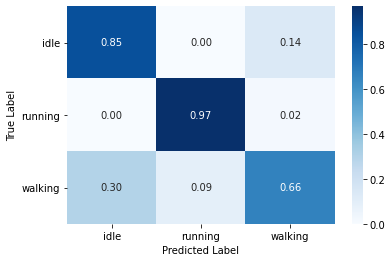

In [6]:
if not os.path.isdir(result_dir):  # For training
    os.mkdir(result_dir)
model.fit_and_save_model(es=False, mc=False, rlr=True, log=True)

In [7]:
# model.plt_fig()